In [31]:
import pandas as pd
import numpy as np
import os 
import sys
import zipfile
from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns

import mysql
import mysql.connector
import pymssql

import lightgbm as lgb
import warnings
import plotly.express as px

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_validate,\
    validation_curve, train_test_split
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_absolute_error


pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'D:\VS code files\store_item_demand_forecasting_challenge\data\train.csv')
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [4]:
def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [5]:
#define sales in different quantile
df[["sales"]].describe([0.10, 0.30, 0.50, 0.70, 0.80, 0.90, 0.95, 0.99]).T

,count,mean,std,min,10%,30%,50%,70%,80%,90%,95%,99%,max
sales,913000.0,52.250287,28.801144,0.0,20.0,33.0,47.0,64.0,76.0,93.0,107.0,135.0,231.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
store,913000.0,5.500000,2.872283,1.0,3.0,5.5,8.0,10.0
item,913000.0,25.500000,14.430878,1.0,13.0,25.5,38.0,50.0
sales,913000.0,52.250287,28.801144,0.0,30.0,47.0,70.0,231.0


In [7]:
df.describe(include='object').T

,count,unique,top,freq
date,913000,1826,2013-01-01,500


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [9]:
# Are there an equal number of unique items in each store?
df.groupby(["store"])["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [10]:
# Sales statistics in store breakdown
df.groupby("store").agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
           sum       mean median        std
store                                      
1      4315603  47.268379   44.0  24.006252
2      6120128  67.033165   62.0  33.595810
3      5435144  59.530602   55.0  29.974102
4      5012639  54.902946   51.0  27.733097
5      3631016  39.770164   37.0  20.365757
6      3627670  39.733516   37.0  20.310451
7      3320009  36.363735   34.0  18.684825
8      5856169  64.142048   60.0  32.231751
9      5025976  55.049025   51.0  27.832186
10     5360158  58.709288   54.0  29.554994

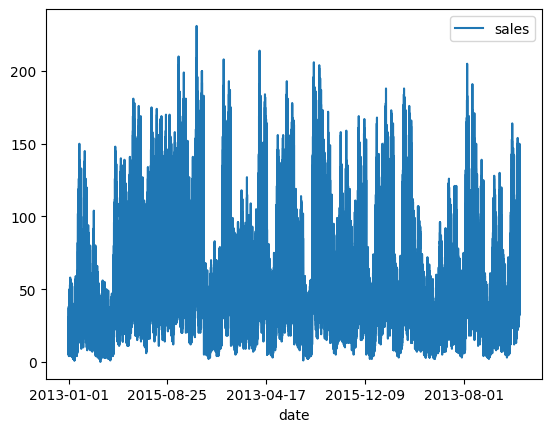

In [11]:
# 2D graphic to see seasonality
df.set_index('date',inplace=True)
df.plot(y= 'sales',kind='line')
df.reset_index(inplace=True)

### Feature Engineering

In [12]:
df['date'].dtype

df['date'] = pd.to_datetime(df['date'])

In [13]:
# Date Features
def create_date_features(dataframe):
    dataframe['month'] = dataframe['date'].dt.month
    dataframe['day_of_month'] = dataframe['date'].dt.day
    dataframe['day_of_year'] = dataframe['date'].dt.dayofyear
    #dataframe['week_of_year'] = dataframe['date'].dt.week
    #dataframe['day_of_week'] = dataframe['date'].dt.dayofweek
    dataframe['year'] = dataframe['date'].dt.year
    dataframe["is_wknd"] = dataframe["date"].dt.weekday // 4
    #dataframe['is_month_start'] = dataframe['is_month_start'].dt.is_month_start.astype(int)
    #dataframe['is_month_end'] = dataframe.date.dt.is_month_end.astype(int)
    return df
df = create_date_features(df)

check_df(df)

##################### Shape #####################
(913000, 9)
##################### Types #####################
date            datetime64[ns]
store                    int64
item                     int64
sales                    int64
month                    int32
day_of_month             int32
day_of_year              int32
year                     int32
is_wknd                  int32
dtype: object
##################### Head #####################
        date  store  item  sales  month  day_of_month  day_of_year  year  is_wknd
0 2013-01-01      1     1     13      1             1            1  2013        0
1 2013-01-02      1     1     11      1             2            2  2013        0
2 2013-01-03      1     1     14      1             3            3  2013        0
3 2013-01-04      1     1     13      1             4            4  2013        1
4 2013-01-05      1     1     10      1             5            5  2013        1
##################### Tail #####################
     

In [14]:
# Sales statistics in store-item-month 
df.groupby(["store", "item", "month"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                    sum       mean median        std
store item month                                    
1     1    1       2125  13.709677   13.0   4.397413
           2       2063  14.631206   14.0   4.668146
           3       2728  17.600000   17.0   4.545013
           4       3118  20.786667   20.0   4.894301
           5       3448  22.245161   22.0   6.564705
...                 ...        ...    ...        ...
10    50   8      13108  84.567742   85.0  15.676527
           9      11831  78.873333   79.0  15.207423
           10     11322  73.045161   72.0  14.209171
           11     11549  76.993333   77.0  16.253651
           12      8724  56.283871   56.0  11.782529

[6000 rows x 4 columns]

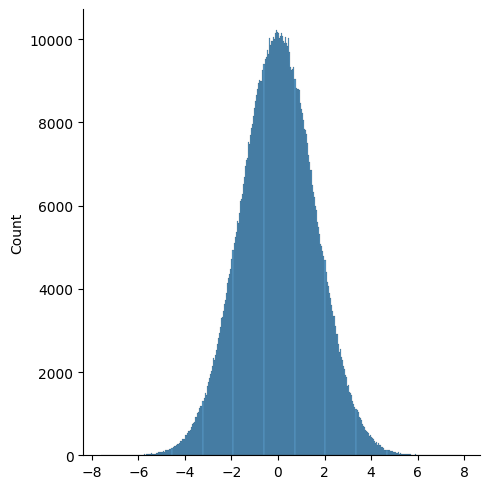

In [15]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

a = np.random.normal(scale=1.6, size=(len(df)))

sns.displot(a)
plt.show()

In [16]:
# The feature order here is important, first we set it as store, item, date.
df.sort_values(by=['store', 'item', 'date'], axis=0, inplace=True)

In [17]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe


df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,year,is_wknd,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
912995,2017-12-27,10,50,63,12,27,361,2017,0,81.553944,73.126236,85.687695,78.427369,79.086030,107.809232,92.411170,43.106618,81.030866,53.075105
912996,2017-12-28,10,50,59,12,28,362,2017,0,82.260502,89.963602,89.509300,76.171179,88.881286,86.765792,118.826436,70.105486,93.036389,45.456002
912997,2017-12-29,10,50,74,12,29,363,2017,1,90.381058,96.221886,93.836811,95.651788,95.186404,97.226164,110.063100,63.375327,102.379335,58.334532
912998,2017-12-30,10,50,62,12,30,364,2017,1,103.365981,93.100694,96.062793,92.477609,94.076226,92.723553,117.807816,64.454114,114.732355,61.339248
912999,2017-12-31,10,50,82,12,31,365,2017,1,97.278139,99.476066,103.300197,96.905186,105.480743,115.518444,115.799721,68.988135,123.204747,81.654082


In [18]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


df = roll_mean_features(df, [365, 546])
df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,year,is_wknd,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546
912995,2017-12-27,10,50,63,12,27,361,2017,0,81.553944,73.126236,85.687695,78.427369,79.086030,107.809232,92.411170,43.106618,81.030866,53.075105,92.074136,82.549573
912996,2017-12-28,10,50,59,12,28,362,2017,0,82.260502,89.963602,89.509300,76.171179,88.881286,86.765792,118.826436,70.105486,93.036389,45.456002,90.841216,84.750290
912997,2017-12-29,10,50,74,12,29,363,2017,1,90.381058,96.221886,93.836811,95.651788,95.186404,97.226164,110.063100,63.375327,102.379335,58.334532,89.384878,84.059361
912998,2017-12-30,10,50,62,12,30,364,2017,1,103.365981,93.100694,96.062793,92.477609,94.076226,92.723553,117.807816,64.454114,114.732355,61.339248,92.395825,80.535667
912999,2017-12-31,10,50,82,12,31,365,2017,1,97.278139,99.476066,103.300197,96.905186,105.480743,115.518444,115.799721,68.988135,123.204747,81.654082,89.821143,83.437037


In [19]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

df.tail()

,date,store,item,sales,month,day_of_month,day_of_year,year,is_wknd,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_ewm_alpha_095_lag_91,sales_ewm_alpha_095_lag_98,sales_ewm_alpha_095_lag_105,sales_ewm_alpha_095_lag_112,sales_ewm_alpha_095_lag_180,sales_ewm_alpha_095_lag_270,sales_ewm_alpha_095_lag_365,sales_ewm_alpha_095_lag_546,sales_ewm_alpha_095_lag_728,sales_ewm_alpha_09_lag_91,sales_ewm_alpha_09_lag_98,sales_ewm_alpha_09_lag_105,sales_ewm_alpha_09_lag_112,sales_ewm_alpha_09_lag_180,sales_ewm_alpha_09_lag_270,sales_ewm_alpha_09_lag_365,sales_ewm_alpha_09_lag_546,sales_ewm_alpha_09_lag_728,sales_ewm_alpha_08_lag_91,sales_ewm_alpha_08_lag_98,sales_ewm_alpha_08_lag_105,sales_ewm_alpha_08_lag_112,sales_ewm_alpha_08_lag_180,sales_ewm_alpha_08_lag_270,sales_ewm_alpha_08_lag_365,sales_ewm_alpha_08_lag_546,sales_ewm_alpha_08_lag_728,sales_ewm_alpha_07_lag_91,sales_ewm_alpha_07_lag_98,sales_ewm_alpha_07_lag_105,sales_ewm_alpha_07_lag_112,sales_ewm_alpha_07_lag_180,sales_ewm_alpha_07_lag_270,sales_ewm_alpha_07_lag_365,sales_ewm_alpha_07_lag_546,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
912995,2017-12-27,10,50,63,12,27,361,2017,0,81.553944,73.126236,85.687695,78.427369,79.086030,107.809232,92.411170,43.106618,81.030866,53.075105,92.074136,82.549573,79.914487,72.548186,83.312732,79.052689,112.421502,99.398046,60.057616,80.309924,50.694458,79.775790,73.014965,82.661721,79.031032,112.682169,97.793775,60.130827,80.559776,50.386242,79.444094,73.830676,81.531275,78.880715,112.703381,94.582035,60.324250,81.003722,49.817414,79.206836,74.678766,80.725736,78.765870,112.055216,91.364220,60.573486,81.586176,49.410597,79.657373,77.143760,80.401219,79.356088,109.036310,84.929217,61.127792,84.107010,49.495322
912996,2017-12-28,10,50,59,12,28,362,2017,0,82.260502,89.963602,89.509300,76.171179,88.881286,86.765792,118.826436,70.105486,93.036389,45.456002,90.841216,84.750290,81.895724,88.177409,89.665637,78.052634,118.671075,109.469902,43.852881,90.465496,44.334723,81.777579,87.401497,89.266172,78.103103,118.368217,108.779377,44.713083,89.955978,44.638624,81.488819,85.966135,88.306255,78.176143,117.740676,106.916407,46.464850,89.000744,45.163483,81.162051,84.703630,87.217721,78.229761,116.916565,104.409266,48.272046,88.175853,45.623179,80.828687,83.071880,85.200610,78.678044,114.018155,97.464609,52.063896,87.553505,46.747661
912997,2017-12-29,10,50,74,12,29,363,2017,1,90.381058,96.221886,93.836811,95.651788,95.186404,97.226164,110.063100,63.375327,102.379335,58.334532,89.384878,84.059361,89.594786,96.558870,93.783282,96.052632,119.933554,66.273495,66.792644,100.473275,58.266736,89.177758,96.040150,93.526617,95.110310,119.836822,68.477938,65.671308,99.895598,57.563862,88.297764,94.793227,92.861251,93.235229,119.548135,72.583281,63.692970,98.600149,56.232697,87.348615,93.311089,91.965316,91.368928,119.074969,76.122780,62.081614,97.152756,54.986954,85.414343,90.035940,89.600305,87.839022,117.009078,80.732304,60.031948,94.276753,52.873830
912998,2017-12-30,10,50,62,12,30,364,2017,1,103.365981,93.100694,96.062793,92.477609,94.076226,92.723553,117.807816,64.454114,114.732355,61.339248,92.395825,80.535667,102.329739,96.977944,96.839164,93.152632,100.046678,104.013675,63.189632,112.373664,62.763337,101.617776,96.904015,96.652662,93.211031,101.083682,102.247794,63.267131,111.689560,62.456386,100.059553,96.558645,96.172250,93.047046,103.109627,99.316656,63.138594,110.120030,61.646539,98.304585,95.893327,95.489595,92.510678,105.022491,97.036834,62.724484,108.245827,60.596086,94.207172,93.517970,93.300152,90.419511,108.004539,93.366152,61.515974,103.638376,57.936915
912999,2017-12-31,10,50,82,12,31,365,2017,1

In [20]:
df = pd.get_dummies(df, columns=['store', 'item', 'month'])



In [21]:
# MAE: mean absolute error
# MAPE: mean absolute percentage error
# SMAPE: Symmetric mean absolute percentage error (adjusted MAPE)

def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [22]:
# Train set until the beginning of 2017 (until the end of 2016).
train = df.loc[(df["date"] < "2017-01-01"), :]

# First three months of 2017 validation set.
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

# Selecting the dependent and independent variable for the train set
Y_train = train['sales']
X_train = train[cols]

# Choosing the dependent and independent variable for the validation set
Y_val = val['sales']
X_val = val[cols]

In [23]:
Y_train.shape, Y_train.shape, Y_val.shape, X_val.shape

((730500,), (730500,), (45000,), (45000, 132))

In [24]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}


lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  feval=lgbm_smape
                  )

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [25]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))


192.17931687846092

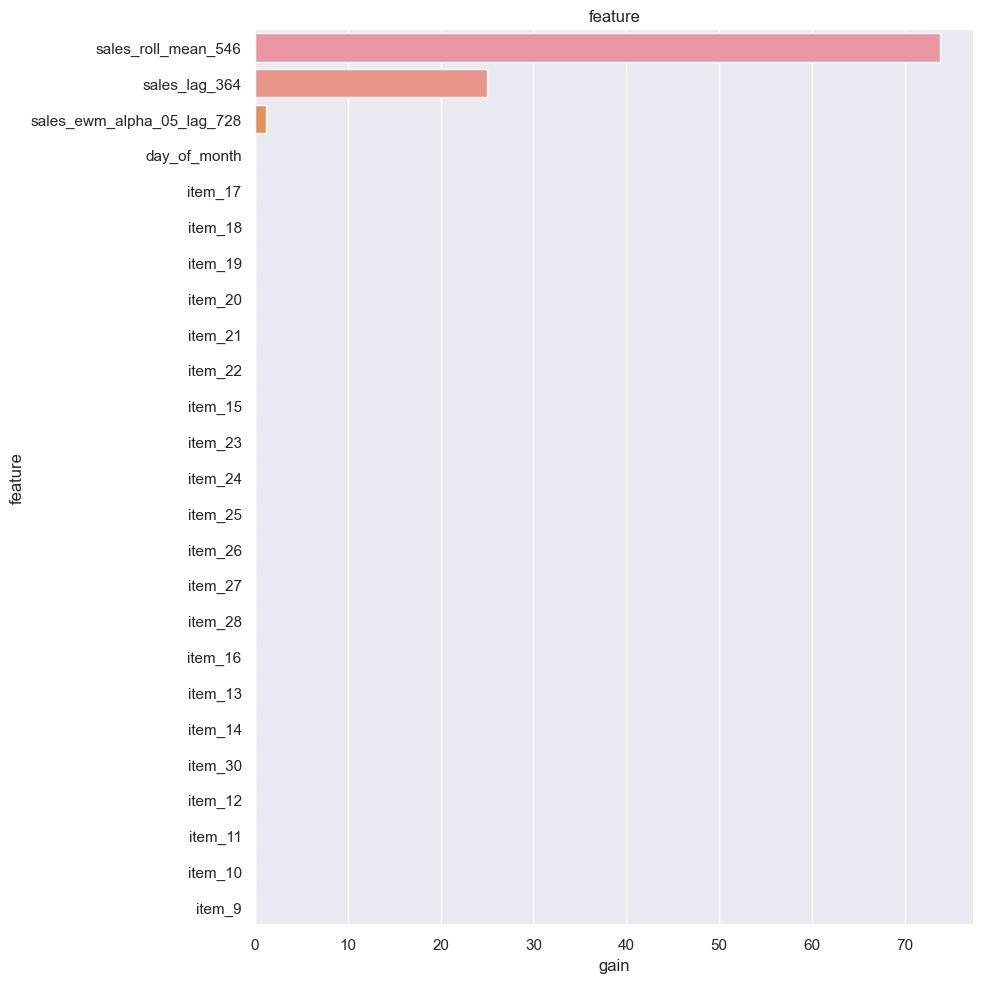

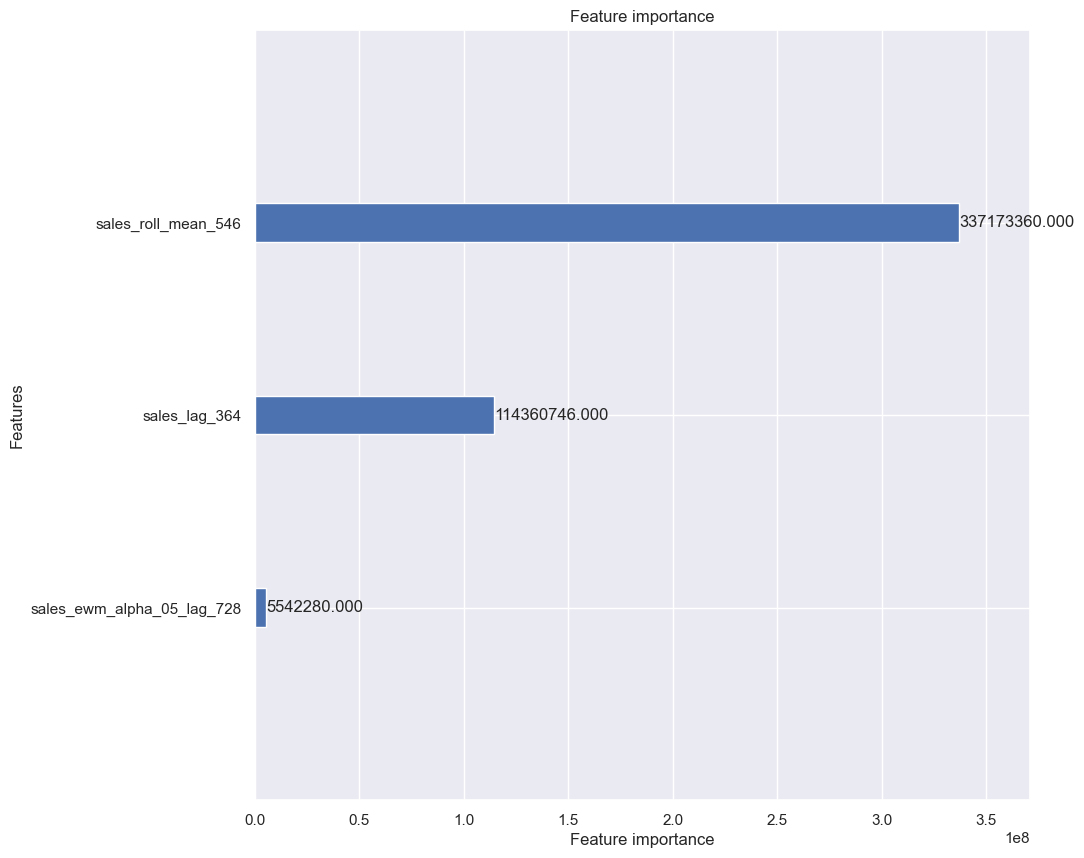

In [26]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

plot_lgb_importances(model, num=30, plot=True)
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [36]:

# Train set: rows where sales is not NaN
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]

# Test set: rows where sales is NaN
test = df.loc[~df.sales.isna()]
X_test = test[cols]

# Ensure X_test is not empty and is 2D
if X_test.empty:
    raise ValueError("X_test is empty. Check your dataframe and feature columns.")
if len(X_test.shape) != 2:
    raise ValueError("X_test must be a 2-dimensional array.")

# LightGBM parameters
lgb_params = {
    'metric': 'mae',
    'num_leaves': 10,
    'learning_rate': 0.02,
    'feature_fraction': 0.8,
    'max_depth': 5,
    'verbose': 0,
    'nthread': -1
}

# LightGBM dataset
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

# Train the model
model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=100)

# Predict using the model
test_preds = model.predict(X_test)

# Print predictions
print(test_preds)

# Assuming you have a validation set to check the accuracy
# Create a validation set (e.g., the first three months of 2017)
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01") & ~df.sales.isna()]
Y_val = val['sales']
X_val = val[cols]

# Predict on validation set
val_preds = model.predict(X_val)

# Calculate and print MAE on validation set
mae_val = mean_absolute_error(Y_val, val_preds)
print(f'Mean Absolute Error on validation set: {mae_val}')

[30.73363577 30.73363577 30.73363577 ... 66.04122205 68.5181511
 73.89975435]
Mean Absolute Error on validation set: 7.75265190685903
